In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

df = pd.read_parquet('parquets/hdbscan_results/hdbscan1000_200_umap30_9_imputed.parquet')

# Lista de features que querés analizar
features = ['zcrall', 'normpeakall', 'spectralTiltall', 'LHratioall', 
            'cppall', 'acflow', 'oq', 'naq', 'h1h2']

# Filtramos datos válidos (excluye ruido si querés)
df_valid = df[df['hdbscan_label'] != -1]

# Función para calcular estadísticas por feature
def summarize_features(group):
    stats = {}
    for feat in features:
        values = group[feat].dropna()
        stats[f'{feat}_mean'] = values.mean()
        stats[f'{feat}_median'] = values.median()
        stats[f'{feat}_std'] = values.std()
        stats[f'{feat}_range'] = values.max() - values.min()
        stats[f'{feat}_skew'] = skew(values)
        stats[f'{feat}_kurtosis'] = kurtosis(values)
    return pd.Series(stats)

# Aplicar por clúster
feature_stats_by_cluster = df_valid.groupby('hdbscan_label').apply(summarize_features)

# Mostrar resumen
pd.set_option('display.max_columns', None)  # Para ver todo
print(feature_stats_by_cluster.round(3))


In [ ]:
from scipy.stats import f_oneway, kruskal
import pandas as pd
import numpy as np
df = pd.read_parquet('parquets/hdbscan_results/hdbscan1000_200_umap30_9_imputed.parquet')

def test_feature_by_cluster(df, feature, clusters):
    # Lista de arrays (uno por clúster)
    groups = [
        df[df['hdbscan_label'] == cl][feature].dropna().values
        for cl in clusters
    ]

    # ANOVA clásico
    try:
        anova_p = f_oneway(*groups).pvalue
    except Exception:
        anova_p = np.nan

    # Kruskal-Wallis
    try:
        kruskal_p = kruskal(*groups).pvalue
    except Exception:
        kruskal_p = np.nan

    # Tamaño de efecto (η²)
    try:
        eta_sq = eta_squared(groups)
    except Exception:
        eta_sq = np.nan

    return pd.Series({
        'anova_p': anova_p,
        'kruskal_p': kruskal_p,
        'eta_sq': eta_sq        # ← nuevo
    })


def eta_squared(groups):
    k = len(groups)
    n_total = sum(len(g) for g in groups)
    grand_mean = np.mean(np.concatenate(groups))
    ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
    ss_total  = sum(((g - grand_mean)**2).sum() for g in groups)
    return ss_between / ss_total


features = [
    'zcrall', 'normpeakall', 'spectralTiltall', 'LHratioall',
    'cppall', 'acflow', 'oq', 'naq', 'h1h2'
]

df_valid = df[df['hdbscan_label'] != -1]
clusters  = sorted(df_valid['hdbscan_label'].unique())

pvals = pd.DataFrame()
for feat in features:
    stats = test_feature_by_cluster(df_valid, feat, clusters)
    pvals[feat] = stats

pvals = pvals.T

# Corrección múltiple (si quiere mantenerla)
m = len(features)
pvals['anova_p_adj']    = (pvals['anova_p']    * m).clip(upper=1.0)
pvals['kruskal_p_adj']  = (pvals['kruskal_p']  * m).clip(upper=1.0)

# Ordene por tamaño de efecto o p-value ajustado, según le interese
print(
    pvals.sort_values('eta_sq', ascending=False)
          .loc[:, ['eta_sq', 'anova_p_adj', 'kruskal_p_adj']]
)



In [ ]:
#LMM
import pandas as pd
import statsmodels.formula.api as smf

# 1. Cargar el DataFrame
df = pd.read_parquet("parquets/no_wind/hdbscan_results/hdbscan1000_50_umap30_5_0p1imputed.parquet")

# 2. Asegurarse que subject_id y cluster sean categóricos
df['subject_id'] = df['subject_id'].astype('category')
df['hdbscan_label'] = df['hdbscan_label'].astype('category')

# 3. Seleccionar una feature para analizar
feature = 'cppall'  # Puedes cambiar esto a cualquier otra feature

# 4. Ajustar modelo LMM
model = smf.mixedlm(
    formula=f"{feature} ~ hdbscan_label",    # efecto fijo: cluster
    data=df,
    groups=df["subject_id"]                  # efecto aleatorio: sujeto
)
result = model.fit(reml=True)

# 5. Ver resumen
print(result.summary())


In [16]:
#GENERAR TABLA CON COHENS D Y BETAS, USANDO LMM

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from tqdm import tqdm

# 1. Cargar DataFrame
df = pd.read_parquet("parquets/no_wind/hdbscan_results/hdbscan1000_50_umap30_5_0p1imputed.parquet")

# 2. Asegurar tipos categóricos
df['subject_id'] = df['subject_id'].astype('category')
df['hdbscan_label'] = df['hdbscan_label'].astype('category')

# 3. Lista de features a analizar
features = ['cppall', 'zcrall', 'normpeakall', 'spectralTiltall', 'LHratioall',
            'acflow', 'oq', 'naq', 'h1h2']

# 4. Extraer lista de clusters (sin el base)
cluster_labels = [label for label in df['hdbscan_label'].cat.categories if label != '0']

# 5. Crear tabla para almacenar resultados
results = []

# 6. Loop por cada feature
for feature in tqdm(features, desc="Procesando features"):

    try:
        # Ajustar LMM
        model = smf.mixedlm(f"{feature} ~ C(hdbscan_label)",
                            df,
                            groups=df["subject_id"],
                            re_formula="1")
        result = model.fit(reml=True)

        # Extraer varianzas
        var_resid = result.scale
        var_subject = result.cov_re.iloc[0, 0]
        s_pooled = np.sqrt(var_resid + var_subject)

        # Extraer betas y calcular d
        row = {'feature': feature}

        for label in cluster_labels:
            param_name = f"C(hdbscan_label)[T.{label}]"
            beta = result.params.get(param_name, np.nan)

            # Calcular d solo si hay beta
            if not np.isnan(beta):
                d = beta / s_pooled
                row[f'beta_cluster_{label}'] = beta
                row[f'd_cluster_{label}'] = d
            else:
                row[f'beta_cluster_{label}'] = np.nan
                row[f'd_cluster_{label}'] = np.nan

        results.append(row)

    except Exception as e:
        print(f"Error en feature '{feature}': {e}")

# 7. Convertir resultados a DataFrame
df_results = pd.DataFrame(results)

df_results.to_csv("tabla_lmm_betas_d.csv", index=False)
print("Tabla guardada como tabla_lmm_betas_d.csv")




Procesando features:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\gdiaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
Procesando features:  11%|█         | 1/9 [00:06<00:53,  6.69s/it]c:\Users\gdiaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\gdiaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
Procesando features:  22%|██▏       | 2/9 [00:12<00:44,  6.40s/it]c:\Users\gdiaz\AppData\Local\Programs\Pyth

Tabla guardada como tabla_lmm_betas_d.csv


In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Configuración general ===
features = ['zcrall', 'normpeakall', 'spectralTiltall', 'LHratioall', 
            'cppall', 'acflow', 'oq', 'naq', 'h1h2']

# Crear carpeta para guardar gráficos
os.makedirs("histogramas_por_feature", exist_ok=True)

# Filtrar puntos válidos (excluye ruido si querés)
df_valid = df[df['hdbscan_label'] != -1]

# Paleta de colores por cluster
palette = sns.color_palette("husl", df_valid['hdbscan_label'].nunique())

# === Graficar cada feature ===
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df_valid,
        x=feature,
        hue='hdbscan_label',
        bins=50,
        kde=False,
        palette=palette,
        stat='density',
        common_norm=False,
        element='step'
    )
    plt.title(f"Distribución de '{feature}' por clúster")
    plt.xlabel(feature)
    plt.ylabel("Densidad")
    plt.legend(title="Cluster", loc="upper right")
    plt.tight_layout()
    plt.savefig(f"histogramas_por_feature/{feature}_histogram_por_cluster.png")
    plt.close()

print("✅ Histogramas guardados en carpeta 'histogramas_por_feature'")


               CAPE_overall  vrqol_total
hdbscan_label                           
0                     12.37        78.78
1                     26.86        68.33
2                     16.02        75.00
3                     26.96        68.08


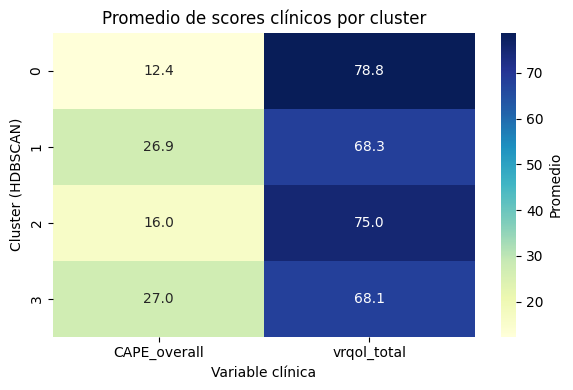

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_parquet('parquets/hdbscan_results/hdbscan1000_200_umap30_9_imputed.parquet')
# Agrupar por cluster y calcular la media
summary_table = df.groupby('hdbscan_label')[['CAPE_overall', 'vrqol_total']].mean().round(2)

# Mostrar como tabla ordenada
print(summary_table.sort_index())

plt.figure(figsize=(6, 4))
sns.heatmap(summary_table, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Promedio'})
plt.title("Promedio de scores clínicos por cluster")
plt.ylabel("Cluster (HDBSCAN)")
plt.xlabel("Variable clínica")
plt.tight_layout()
plt.show()


Total de puntos: 85649


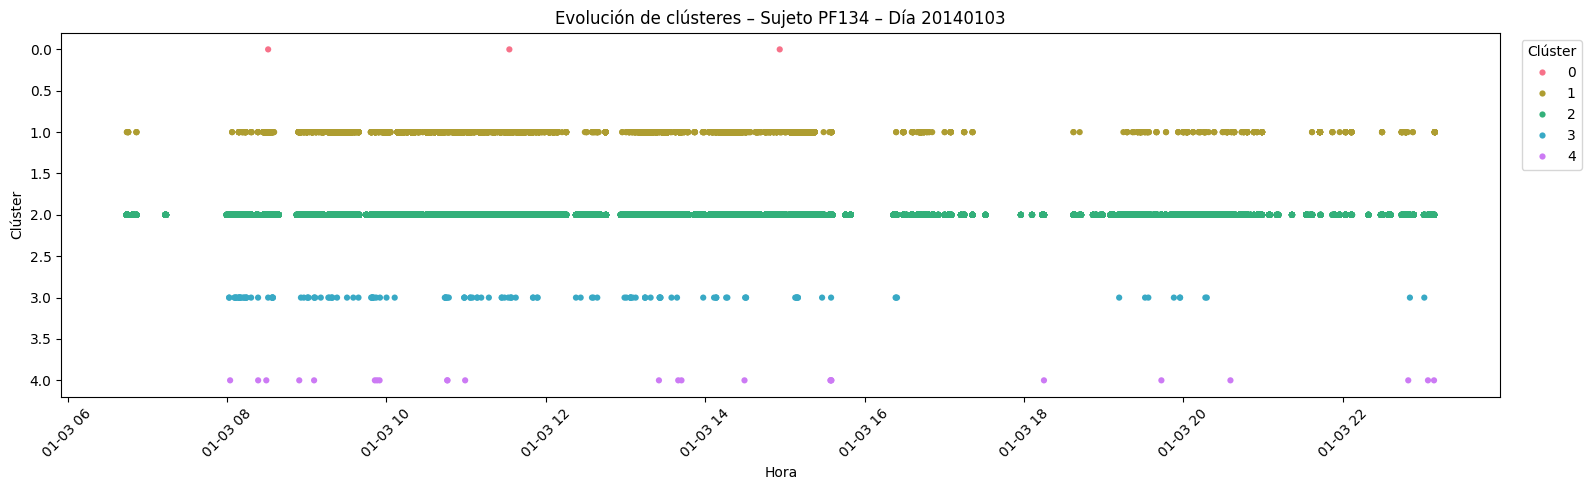

Total de puntos: 64544


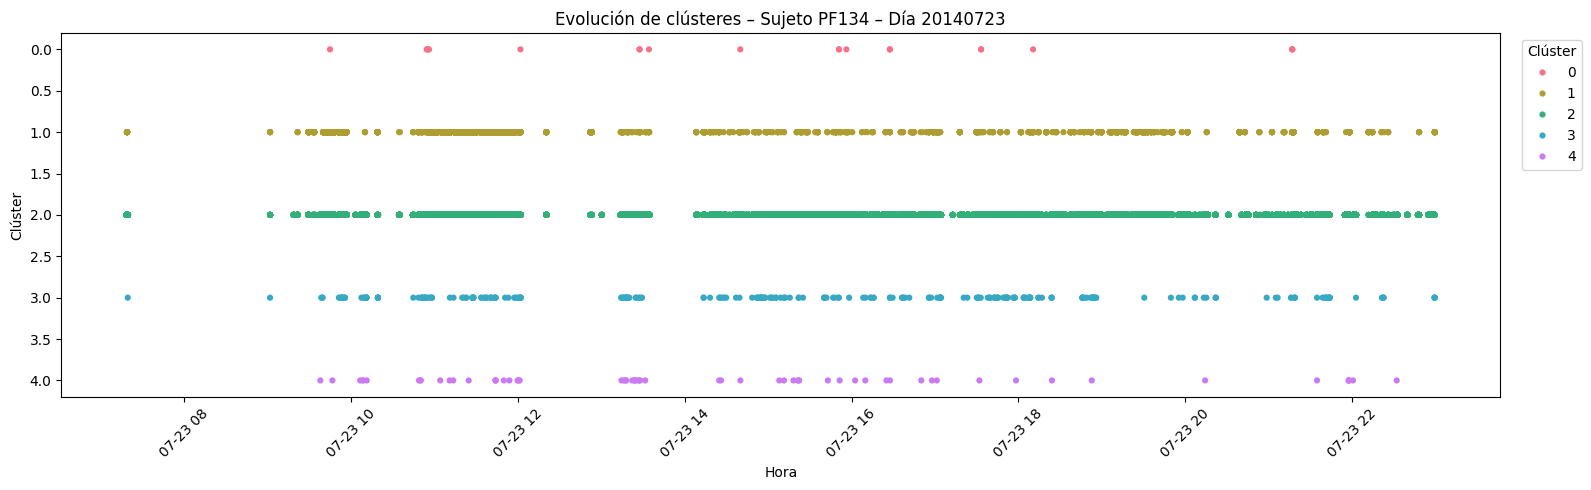

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Configurar sujeto y fecha específica ===
subject_id = 'PF134'
fecha = '20140103'

# === Filtrar solo ese día y ese sujeto ===
df_day = df[(df['subject_id'] == subject_id) &
            (df['date'] == fecha) &
            (df['hdbscan_label'] != -1)].copy()

df_day = df_day.sort_values('ts')
print(f"Total de puntos: {len(df_day)}")

# === Graficar clúster vs tiempo ===
plt.figure(figsize=(16, 5))
sns.scatterplot(
    data=df_day,
    x='ts',
    y='hdbscan_label',
    hue='hdbscan_label',
    palette='husl',
    s=20,
    linewidth=0
)

plt.title(f'Evolución de clústeres – Sujeto {subject_id} – Día {fecha}')
plt.xlabel("Hora")
plt.ylabel("Clúster")
plt.xticks(rotation=45)
plt.legend(title='Clúster', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === Configurar sujeto y fecha específica ===
subject_id = 'PF134'
fecha = '20140723'

# === Filtrar solo ese día y ese sujeto ===
df_day = df[(df['subject_id'] == subject_id) &
            (df['date'] == fecha) &
            (df['hdbscan_label'] != -1)].copy()

df_day = df_day.sort_values('ts')
print(f"Total de puntos: {len(df_day)}")

# === Graficar clúster vs tiempo ===
plt.figure(figsize=(16, 5))
sns.scatterplot(
    data=df_day,
    x='ts',
    y='hdbscan_label',
    hue='hdbscan_label',
    palette='husl',
    s=20,
    linewidth=0
)

plt.title(f'Evolución de clústeres – Sujeto {subject_id} – Día {fecha}')
plt.xlabel("Hora")
plt.ylabel("Clúster")
plt.xticks(rotation=45)
plt.legend(title='Clúster', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()
